In [1]:
import numpy as np
from api.auton import datasets, preprocessing

In [2]:
# Load the SUPPORT Dataset
outcomes, features = datasets.load_dataset('SUPPORT')

In [3]:
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 
             'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp', 'adls']

features = preprocessing.Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)
features

,age,num.co,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,...,dzclass_Coma,income_$25-$50k,income_>$50k,income_under $11k,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes
0,0.012772,-1.390013,0.449837,-6.931821e-01,-0.892283,-0.138967,-0.881504,1.569019e+00,-1.655686e+00,-5.238337e-01,...,0,0,0,0,0,0,1,0,0,0
1,-0.148262,0.097711,-1.500702,5.187096e-01,0.470382,1.114591,-2.005013,-1.495658e+00,-6.389701e-16,9.880260e-17,...,0,0,0,0,0,0,0,1,1,0
2,-0.635153,0.097711,-0.525432,-4.201759e-01,-0.290175,0.487812,0.235766,-8.319880e-02,-6.389701e-16,-7.892740e-02,...,0,0,0,1,0,0,0,1,1,0
3,-1.299688,0.097711,-0.344827,-3.546971e-01,-0.290175,0.905665,-1.680444,-3.003564e-16,-6.389701e-16,9.880260e-17,...,0,0,0,1,0,0,0,1,0,0
4,1.105258,-0.646151,-0.922764,1.258366e-01,0.470382,-0.347893,0.635237,-6.997670e-01,-6.389701e-16,9.880260e-17,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,0.219471,-0.646151,0.883291,-5.403626e-01,0.216863,-0.138967,-1.124933,4.276908e-01,1.077955e+00,-4.793410e-01,...,0,0,0,0,0,0,0,1,1,0
9101,-0.480786,-0.646151,-1.500702,1.939826e-16,-3.078884,-1.601451,1.190748,-2.222321e-01,-6.389701e-16,9.880260e-17,...,1,0,0,0,0,0,0,1,1,0
9102,0.495813,-0.646151,0.955533,-4.312668e-01,-0.448624,0.069960,-0.325992,-6.290945e-01,-6.389701e-16,-4.793410e-01,...,0,0,0,0,0,0,0,1,1,0
9103,-1.002436,-0.646151,0.522080,-5.185008e-01,0.407002,0.069960,-0.563174,1.997678e+00,-2.518775e+00,-4.793410e-01,...,0,0,0,0,0,0,0,1,0,1


In [4]:
x, t, e = features.values, outcomes.time.values, outcomes.event.values
x = x[:,:6]
x

array([[ 0.01277233, -1.39001299,  0.44983742, -0.69318213, -0.89228251,
        -0.1389668 ],
       [-0.14826234,  0.09771103, -1.50070191,  0.5187096 ,  0.47038189,
         1.1145915 ],
       [-0.63515269,  0.09771103, -0.52543225, -0.4201759 , -0.29017498,
         0.48781235],
       ...,
       [ 0.49581285, -0.64615098,  0.9555328 , -0.43126678, -0.44862433,
         0.06995959],
       [-1.00243569, -0.64615098,  0.52207962, -0.5185008 ,  0.40700215,
         0.06995959],
       [ 1.21133166, -0.64615098, -0.34482675, -0.40929831, -0.89228251,
         0.06995959]])

In [5]:
import numpy as np
horizons = [0.25, 0.5, 0.75]
times = np.quantile(outcomes.time[outcomes.event==1], horizons).tolist()
times

[14.0, 58.0, 252.0]

In [6]:
n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]

### Get started with KANs

Initialize KAN

In [7]:
x_train

array([[ 0.01277233, -1.39001299,  0.44983742, -0.69318213, -0.89228251,
        -0.1389668 ],
       [-0.14826234,  0.09771103, -1.50070191,  0.5187096 ,  0.47038189,
         1.1145915 ],
       [-0.63515269,  0.09771103, -0.52543225, -0.4201759 , -0.29017498,
         0.48781235],
       ...,
       [ 0.2831526 ,  0.09771103,  1.64183368,  0.3005179 ,  0.53376163,
         0.48781235],
       [-1.61893671, -0.64615098, -0.09197906, -0.13629207,  0.09010345,
         0.06995959],
       [ 0.97443018, -0.64615098, -0.52543225, -1.27196068,  0.47038189,
         1.95029703]])

In [8]:
x_train.shape[1]

6

In [9]:
from api.coxkan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[x_train.shape[1],1], grid=5, k=3, seed=0)
# model = KAN(width=[2,1,1], grid=5, k=3, seed=0)
optimizer = 'Adam'

Create dataset

In [10]:
device='cpu'
dataset = {
    'train_input': torch.from_numpy(x_train).to(device), 
    'val_input': torch.from_numpy(x_val).to(device),
    'test_input': torch.from_numpy(x_test).to(device),
    'train_time': torch.from_numpy(t_train).to(device), 
    'val_time': torch.from_numpy(t_val).to(device),
    'test_time': torch.from_numpy(t_test).to(device),
    'train_event': torch.from_numpy(e_train).to(device),
    'val_event': torch.from_numpy(e_val).to(device),
    'test_event': torch.from_numpy(e_test).to(device)}

Plot KAN at initialization

In [11]:
dataset['train_input'].shape

torch.Size([6373, 6])

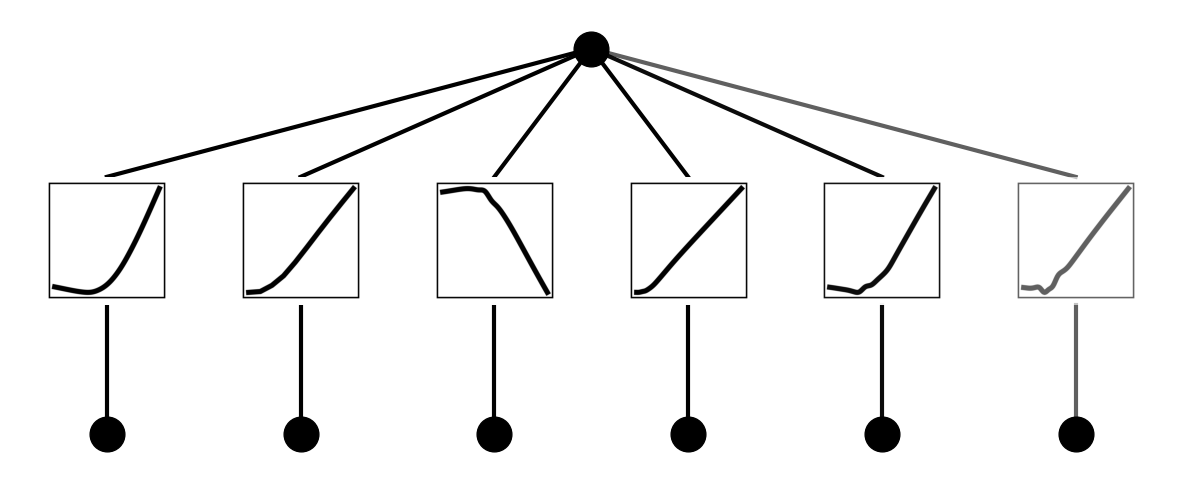

In [12]:
# plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100, scale=1.5)

Train KAN with sparsity regularization

In [13]:
# train the model
model.train()
model.fit(dataset, opt=optimizer, steps=20, lr=0.0001, lamb=0.01, lamb_entropy=10.)

train loss: 9.28e+01 | reg: 1.96e+01 : 100%|████████████████████████| 20/20 [00:00<00:00, 71.44it/s]


{'train_loss': [array(30.87517752),
  array(31.7306556),
  array(29.97132737),
  array(30.40141734),
  array(28.9613637),
  array(30.66626175),
  array(30.86051858),
  array(29.75741152),
  array(30.69235582),
  array(42.94812954),
  array(30.73213747),
  array(40.24862534),
  array(32.89096157),
  array(30.50946076),
  array(31.12032364),
  array(34.81314058),
  array(30.83656743),
  array(30.16006542),
  array(46.07789917),
  array(92.82207369)],
 'test_loss': [],
 'reg': [array(20.19848046),
  array(20.63528016),
  array(20.26562039),
  array(20.31662699),
  array(20.30506047),
  array(20.85383852),
  array(21.24463764),
  array(20.51427047),
  array(21.09101739),
  array(21.28639696),
  array(20.85691143),
  array(21.32736644),
  array(20.98668934),
  array(21.30864233),
  array(21.34793601),
  array(20.36754291),
  array(20.81335025),
  array(20.45073798),
  array(9.23069918),
  array(19.63559544)]}

Plot trained KAN

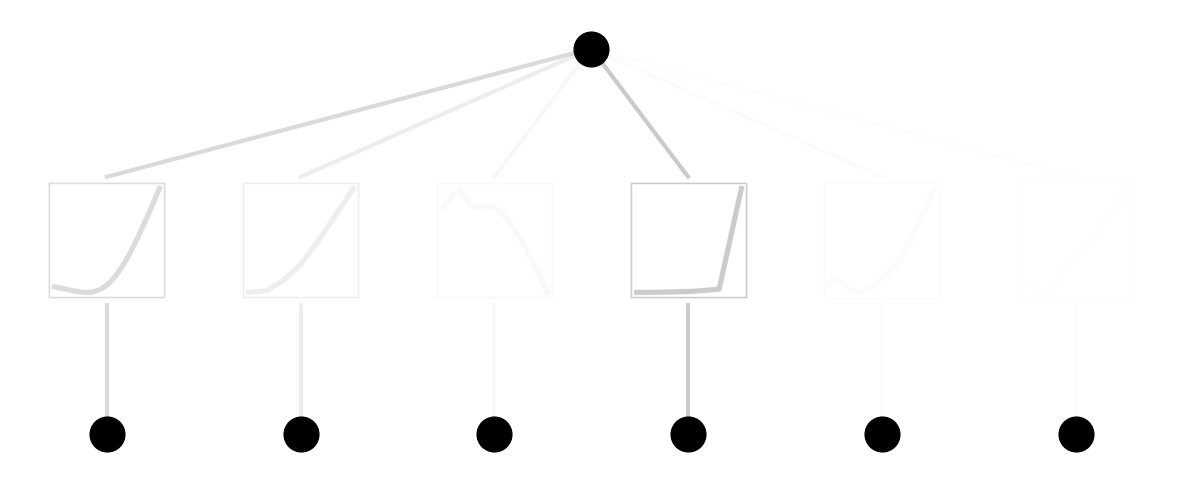

In [14]:
model.plot(scale=1.5)

Prune KAN and replot (keep the original shape)

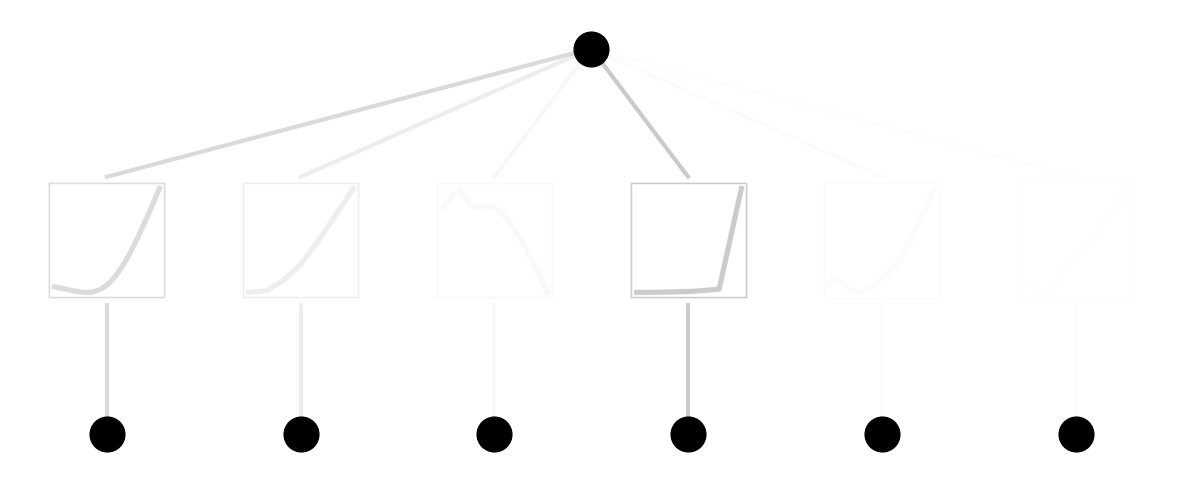

In [15]:
model.prune()
model.plot(mask=True, scale=1.5)

Prune KAN and replot (get a smaller shape)

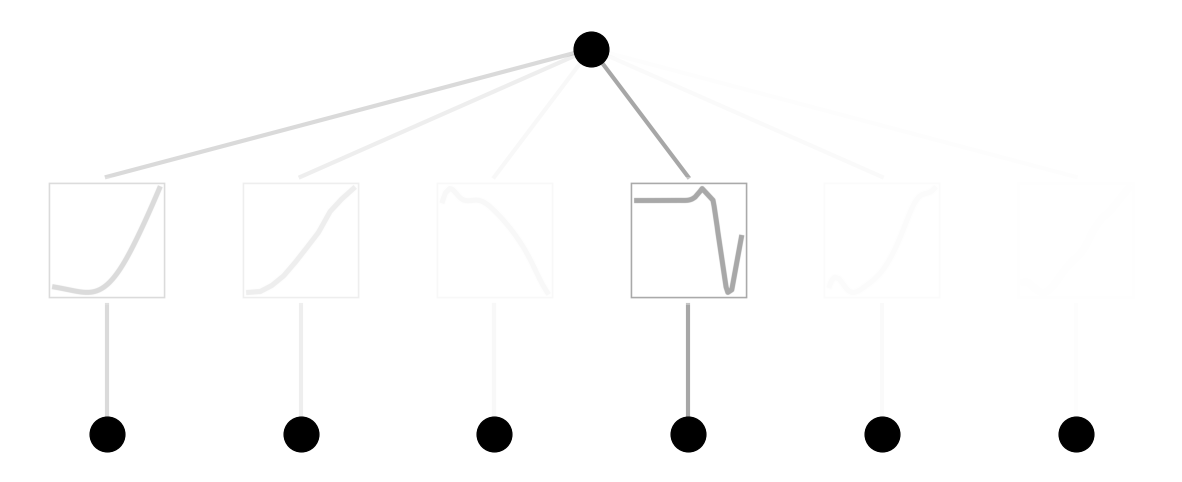

In [16]:
model = model.prune()
model(dataset['train_input'])
model.plot(scale=1.5)

Continue training and replot

In [17]:
model.fit(dataset, opt=optimizer, steps=50)

train loss: 3.58e+01 | reg: 4.23e+00 : 100%|████████████████████████| 50/50 [00:00<00:00, 98.33it/s]


{'train_loss': [array(86.67030763),
  array(39.57199165),
  array(43.33704246),
  array(57.40217158),
  array(61.66500239),
  array(42.37378522),
  array(39.90902807),
  array(34.25663191),
  array(34.41867659),
  array(63.4602836),
  array(40.58557826),
  array(37.50551606),
  array(44.02502693),
  array(43.91817034),
  array(49.76250335),
  array(49.03961757),
  array(45.97770627),
  array(47.97651547),
  array(178.66399502),
  array(46.18794489),
  array(44.72443999),
  array(41.4884582),
  array(40.23628687),
  array(40.56334072),
  array(46.12407003),
  array(42.85945172),
  array(44.28358747),
  array(49.010206),
  array(44.04803672),
  array(41.79310941),
  array(42.92854676),
  array(44.17405324),
  array(37.64940191),
  array(37.03678226),
  array(41.14731615),
  array(38.51760738),
  array(39.75245268),
  array(40.97530674),
  array(43.42960151),
  array(42.26573398),
  array(42.10751231),
  array(42.16804761),
  array(39.57116567),
  array(37.14326202),
  array(38.20945131),

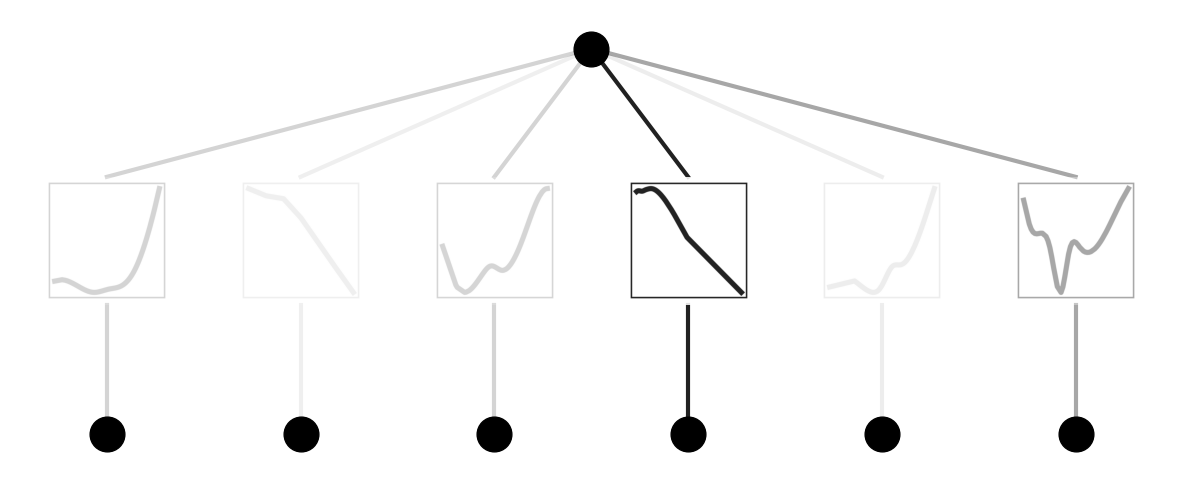

In [18]:
model.plot(scale=1.5)

Automatically or manually set activation functions to be symbolic

In [19]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^4, r2=0.9851347004833576
fixing (0,1,0) with tanh, r2=0.9864353105025633
fixing (0,2,0) with tanh, r2=0.9281136470777368
fixing (0,3,0) with sin, r2=0.9874823705065133
fixing (0,4,0) with x^2, r2=0.9215663696829485
fixing (0,5,0) with abs, r2=0.621659556271661


Continue training to almost machine precision

In [20]:
model.fit(dataset, opt=optimizer, steps=50)

train loss: 3.60e+01 | reg: 6.63e+00 : 100%|████████████████████████| 50/50 [00:00<00:00, 92.50it/s]


{'train_loss': [array(35.87758593),
  array(1853.72895894),
  array(987.16196571),
  array(388.82487916),
  array(1325.04147378),
  array(802.52595063),
  array(536.22401112),
  array(137.22787613),
  array(116.75180671),
  array(89.49003415),
  array(91.14882381),
  array(116.20865205),
  array(100.28762286),
  array(102.01464091),
  array(105.03117767),
  array(120.8745852),
  array(152.04500567),
  array(193.5049406),
  array(222.45392591),
  array(252.29747399),
  array(302.25684164),
  array(314.93419908),
  array(376.97275208),
  array(351.78669832),
  array(348.80904843),
  array(401.97478252),
  array(358.98036395),
  array(297.75037449),
  array(275.01391324),
  array(240.89547013),
  array(195.01192491),
  array(193.38931338),
  array(159.07527704),
  array(148.92631737),
  array(136.1789616),
  array(112.88113774),
  array(102.36411373),
  array(84.08919208),
  array(84.30301778),
  array(80.9105415),
  array(75.24007981),
  array(70.15381116),
  array(65.24205943),
  array(

Obtain the symbolic formula

In [21]:
model.symbolic_formula()[0][0]

0.54*(1 - 0.01*x_5)**2 - 0.1*(x_1 - 0.4)**4 - 34.39*sin(0.1*x_4 - 1.39) + 0.66*tanh(0.7*x_2 + 12.25) + 3.81*tanh(0.56*x_3 + 11.55) + 0.1*Abs(2.79*x_6 + 2.93) - 81.78

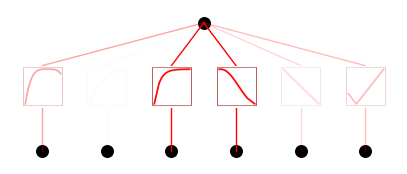

In [22]:
model.plot()

In [23]:
model(dataset['test_input'])

tensor([[-42.9334],
        [-42.5604],
        [-48.9992],
        ...,
        [-42.3873],
        [-42.7397],
        [-42.4354]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [34]:
out_risk = model.predict_risk(dataset, times)
out_survival = model.predict_survival(dataset, times)
# out_risk = model(dataset['test_input']).detach().cpu().numpy()
# out_survival = - model(dataset['test_input']).detach().cpu().numpy()

In [44]:
BreslowEstimator().fit(
    model(dataset['train_input']).detach().cpu().numpy(), 
    dataset['train_event'].numpy(), 
    dataset['train_time'].numpy())

In [45]:
BreslowEstimator()

In [36]:
out_survival

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [33]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

cis, brs = [], []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))], dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))], dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))], dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
    
brs.append(brier_score(et_train, et_test, out_survival, times)[1])

roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
    
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

IndexError: index 1 is out of bounds for axis 1 with size 1

In [26]:
from sksurv.linear_model.coxph import BreslowEstimator


def fit_breslow(model, data):
    return BreslowEstimator().fit(model(data['train_input']).detach().cpu().numpy(), data['train_event'].numpy(), data['train_time'].numpy())

breslow_spline = fit_breslow(model, dataset)

In [27]:
unique_times = breslow_spline.baseline_survival_.x
unique_times

array([   3,    4,    5, ..., 2027, 2028, 2029])

In [28]:
breslow_spline.get_survival_function(model(dataset['train_input']).detach().cpu().numpy())

array([StepFunction(x=array([   3,    4,    5, ..., 2027, 2028, 2029]), y=array([0., 0., 0., ..., 0., 0., 0.]), a=1.0, b=0.0),
       StepFunction(x=array([   3,    4,    5, ..., 2027, 2028, 2029]), y=array([0., 0., 0., ..., 0., 0., 0.]), a=1.0, b=0.0),
       StepFunction(x=array([   3,    4,    5, ..., 2027, 2028, 2029]), y=array([0., 0., 0., ..., 0., 0., 0.]), a=1.0, b=0.0),
       ...,
       StepFunction(x=array([   3,    4,    5, ..., 2027, 2028, 2029]), y=array([0., 0., 0., ..., 0., 0., 0.]), a=1.0, b=0.0),
       StepFunction(x=array([   3,    4,    5, ..., 2027, 2028, 2029]), y=array([0., 0., 0., ..., 0., 0., 0.]), a=1.0, b=0.0),
       StepFunction(x=array([   3,    4,    5, ..., 2027, 2028, 2029]), y=array([0., 0., 0., ..., 0., 0., 0.]), a=1.0, b=0.0)],
      dtype=object)

In [29]:
import pandas as pd

raw_predictions = breslow_spline.get_survival_function(model(dataset['train_input']).detach().cpu().numpy())
raw_predictions = np.array([pred.y for pred in raw_predictions])

predictions = pd.DataFrame(data=raw_predictions, columns=unique_times)